In [1]:
import numpy as np
import pandas as pd

import time
from datetime import datetime

import gensim
import matplotlib.pyplot as plt

import en_nlp_utils
import model_evaluation_utils

In [2]:
# Define default source path
SRC_PATH = "src/"

start_time = datetime.now()
print("Text processing started at {}".format(start_time))

Text processing started at 2024-06-27 02:07:24.951532


In [3]:
# Load dataset
df_review = pd.read_csv(SRC_PATH + "en_hotel_review.csv")

In [4]:
# Check NULL values
en_nlp_utils.check_null(df_review, "df_review")

# Remove rows when "review_cleaned_v2" is NULL
df_review = df_review.dropna(subset=["review_cleaned_v2"]).reset_index(drop=True)

df_review:
source                     0
hotel_id                   0
hotel_name                 0
country                    0
group_name                 0
room_type                  0
stay_length                0
stay_date                  0
review_score               0
review_score_category      0
sentiment                  0
review_date                0
review_title               1
review                     0
review_cleaned_v1          0
review_cleaned_v2        229
dtype: int64
Total rows in df_review: 39831 



## 1) Using full dataset

In [5]:
# Convert "stay_date" and "review_date" columns as datetime data type
df_review["stay_date"] = pd.to_datetime(df_review["stay_date"], format="%d/%m/%Y")

# Count number of reviews based on year and sentiment
sentiment_count = df_review.groupby([df_review["sentiment"], df_review["stay_date"].dt.year]).size().reset_index(name="count")
sentiment_count2 = sentiment_count.pivot_table(index="stay_date", columns="sentiment", values="count", 
                                               aggfunc="sum", margins=True, margins_name="Total")
sentiment_count2.columns.name = None
sentiment_count2

,negative,positive,Total
stay_date,,,
2022,1688,5518,7206
2023,5347,21240,26587
2024,1098,4711,5809
Total,8133,31469,39602


## 2) Topic Modeling

### a) Helper functions

In [6]:
# Function to generate bow corpus
def generate_bow_corpus(df, target_text):
    
    documents = [en_nlp_utils.tokenize_sentence_to_words(cleaned_review) for cleaned_review in df[target_text]]
    
    bigram = gensim.models.Phrases(documents, min_count=20, threshold=20, delimiter="_") # higher threshold fewer phrases.
    bigram_model = gensim.models.phrases.Phraser(bigram)
    
    corpus_bigrams = [bigram_model[doc] for doc in documents]
    dictionary = gensim.corpora.Dictionary(corpus_bigrams)
    dictionary.filter_extremes(no_below=20, no_above=0.6)
    bow_corpus = [dictionary.doc2bow(text) for text in corpus_bigrams]
    
    return bow_corpus, corpus_bigrams, dictionary


# Function to calculate all models' coherence scores
def topic_model_coherence_plot(df, df_name, target_text, MODEL_NAMES, START_TOPIC_COUNT, END_TOPIC_COUNT):
    
    overall_coherence_df = pd.DataFrame() # Store each model's coherence scores
    model_topic_info = [] # Store each model's topic information
    
    bow_corpus, corpus_bigrams, dictionary = generate_bow_corpus(df, target_text)
    model_count = 0
    
    for MODEL_NAME in MODEL_NAMES:
        models, coherence_scores = en_nlp_utils.topic_model_coherence_generator(model_name=MODEL_NAME,
                                                                                corpus=bow_corpus,
                                                                                texts=corpus_bigrams,
                                                                                dictionary=dictionary,
                                                                                start_topic_count=START_TOPIC_COUNT,
                                                                                end_topic_count=END_TOPIC_COUNT,
                                                                                step=1,
                                                                                cpus=-1,
                                                                                print_topics=True)

        coherence_df = pd.DataFrame({"Model Name": MODEL_NAME, 
                                     "Number of Topics": range(START_TOPIC_COUNT, END_TOPIC_COUNT + 1, 1), 
                                     "Coherence Score": np.round(coherence_scores, 6),
                                     "df_name": df_name})
        coherence_df.sort_values(by=["Coherence Score"], ascending=False)
        print(coherence_df)
        
        overall_coherence_df = pd.concat([overall_coherence_df, coherence_df], axis=0)
        
        model_topics = []
        for model in models:
            num_topics = model.num_topics
            topics = [[(term, round(wt, 3)) for term, wt in model.show_topic(n, topn=10)] for n in range(num_topics)]
            
            # Determine the number of columns dynamically
            num_terms_per_topic = max(len(topic) for topic in topics)
            
            # Create a DataFrame for topics with dynamic columns and names
            topics_df = pd.DataFrame([[term if len(topic) > i else "" for i, (term, wt) in enumerate(topic)]
                                      for topic in topics],
                                     columns=[f"Term{i+1}" for i in range(num_terms_per_topic)],
                                     index=[f"Topic {t+1}" for t in range(num_topics)]).T
            
            model_topic_info.append({
                "Model Name": MODEL_NAME,
                "Number of Topics": num_topics,
                "Topics": topics_df.to_dict(orient="list"),  # Convert DataFrame to dictionary
                "df_name": df_name
            })
        
        x_ax = range(START_TOPIC_COUNT, END_TOPIC_COUNT + 1, 1)
        y_ax = coherence_scores
        plt.figure(num=model_count, figsize=(15, 12))
        plt.plot(x_ax, y_ax, c="r")
        plt.axhline(y=0.3, c="k", linestyle="--", linewidth=2)
        plt.axhline(y=0.4, c="k", linestyle="--", linewidth=2)
        plt.axhline(y=0.5, c="k", linestyle="--", linewidth=2)
        plt.rcParams["figure.facecolor"] = "white"
        xl = plt.xlabel("Number of Topics")
        yl = plt.ylabel("Coherence Score")

        model_count += 1

    plt.show()
    return overall_coherence_df, model_topic_info


# Function to print best model's topics
def print_best_model_topics(overall_coherence_best_df, model_topic_info_list):
    
    for index, row in overall_coherence_best_df.iterrows():
        model_name = row["Model Name"]
        num_topics = row["Number of Topics"]
        df_name = row["df_name"]
        
        print(f"\nDF NAME: {df_name}\nMODEL: {model_name} - NUMBER OF TOPICS: {num_topics}")
       
        # Find the corresponding model_topic_info
        for model_topic_info in model_topic_info_list:
            for model_info in model_topic_info:
                if (model_info["Model Name"] == model_name and
                    model_info["Number of Topics"] == num_topics and
                    model_info["df_name"] == df_name):
                    
                    topics = model_info["Topics"]
                    for topic_num, terms in topics.items():
                        print(f"\n{topic_num}: {', '.join(terms)}")
                        
                    print("\n----------\n")
                    break

### b) Topic Modeling

In [7]:
# Filter positive and negative reviews and save into different dataframe
df_pos = df_review[df_review["sentiment"] == "positive"].reset_index(drop=True)
df_neg = df_review[df_review["sentiment"] == "negative"].reset_index(drop=True)

In [8]:
MODEL_NAMES = ["LSI", "LDA"]
START_TOPIC_COUNT = 2
END_TOPIC_COUNT = 10

df_sets = [df_pos, df_neg]
df_names = ["df_pos", "df_neg"]


DF NAME: df_pos



  0%|                                                                                            | 0/9 [00:00<?, ?it/s]


MODEL: LSI - NUMBER OF TOPICS: 2


 11%|█████████                                                                        | 1/9 [09:54<1:19:19, 594.89s/it]

Topic #1:
0.415*"good" + 0.380*"staff" + 0.291*"clean" + 0.181*"great" + 0.149*"nice" + 0.149*"also" + 0.144*"check" + 0.143*"friendly" + 0.139*"small" + 0.130*"bed" + 0.109*"meet" + 0.107*"near" + 0.107*"need" + 0.107*"helpful" + 0.104*"well" + 0.102*"breakfast" + 0.101*"food" + 0.095*"like" + 0.089*"overall" + 0.089*"area"

Topic #2:
-0.850*"good" + 0.331*"staff" + 0.205*"check" + 0.127*"great" + 0.102*"friendly" + 0.082*"book" + 0.077*"helpful" + 0.063*"clean" + 0.057*"also" + 0.053*"nice" + 0.052*"ask" + 0.050*"make" + 0.048*"pm" + 0.046*"tell" + 0.046*"give" + 0.045*"could" + 0.043*"guest" + 0.042*"say" + 0.039*"reception" + 0.038*"call"

--------------------------------------------------

MODEL: LSI - NUMBER OF TOPICS: 3


 22%|██████████████████                                                               | 2/9 [20:23<1:11:44, 614.88s/it]

Topic #1:
0.419*"good" + 0.390*"staff" + 0.291*"clean" + 0.178*"great" + 0.149*"nice" + 0.147*"friendly" + 0.146*"also" + 0.143*"check" + 0.135*"small" + 0.127*"bed" + 0.110*"helpful" + 0.108*"meet" + 0.106*"near" + 0.106*"need" + 0.102*"well" + 0.101*"breakfast" + 0.100*"food" + 0.093*"like" + 0.089*"overall" + 0.088*"area"

Topic #2:
-0.839*"good" + 0.387*"staff" + 0.167*"check" + 0.153*"great" + 0.129*"friendly" + 0.095*"helpful" + 0.071*"clean" + 0.061*"nice" + 0.059*"book" + 0.048*"make" + 0.044*"also" + 0.043*"ask" + 0.039*"guest" + 0.039*"pm" + 0.037*"tell" + 0.037*"give" + 0.036*"could" + 0.035*"say" + 0.033*"call" + 0.033*"reception"

Topic #3:
-0.608*"staff" + -0.280*"friendly" + -0.225*"good" + 0.205*"check" + 0.184*"bed" + 0.181*"small" + -0.179*"helpful" + 0.170*"book" + 0.166*"also" + 0.105*"like" + 0.097*"shower" + 0.094*"bathroom" + 0.094*"need" + 0.087*"toilet" + 0.080*"use" + 0.076*"near" + 0.070*"walk" + 0.070*"well" + 0.069*"god" + 0.069*"quite"

-------------------

 33%|███████████████████████████                                                      | 3/9 [30:50<1:02:01, 620.20s/it]

Topic #1:
0.417*"good" + 0.389*"staff" + 0.291*"clean" + 0.179*"great" + 0.150*"nice" + 0.147*"friendly" + 0.147*"also" + 0.142*"check" + 0.136*"small" + 0.127*"bed" + 0.109*"helpful" + 0.108*"meet" + 0.106*"near" + 0.106*"need" + 0.103*"well" + 0.101*"breakfast" + 0.100*"food" + 0.094*"like" + 0.089*"overall" + 0.088*"area"

Topic #2:
-0.861*"good" + 0.346*"staff" + 0.156*"great" + 0.143*"check" + 0.121*"friendly" + 0.109*"clean" + 0.090*"helpful" + 0.071*"nice" + 0.052*"book" + 0.052*"also" + 0.046*"make" + 0.036*"ask" + 0.036*"could" + 0.035*"guest" + 0.034*"give" + 0.031*"pm" + 0.030*"tell" + 0.029*"reception" + 0.029*"say" + 0.029*"even"

Topic #3:
-0.658*"staff" + -0.274*"friendly" + -0.221*"good" + 0.207*"small" + 0.193*"bed" + -0.174*"helpful" + 0.163*"also" + 0.104*"shower" + 0.103*"bathroom" + 0.102*"book" + 0.100*"like" + 0.090*"need" + 0.090*"walk" + 0.089*"near" + 0.085*"area" + 0.084*"meet" + 0.083*"well" + 0.083*"toilet" + 0.082*"use" + 0.073*"clean"

Topic #4:
-0.631*"c

 44%|████████████████████████████████████▉                                              | 4/9 [41:24<52:08, 625.63s/it]

Topic #1:
0.417*"good" + 0.389*"staff" + 0.292*"clean" + 0.179*"great" + 0.150*"nice" + 0.147*"friendly" + 0.147*"also" + 0.142*"check" + 0.136*"small" + 0.127*"bed" + 0.110*"helpful" + 0.108*"meet" + 0.106*"near" + 0.106*"need" + 0.103*"well" + 0.101*"breakfast" + 0.100*"food" + 0.094*"like" + 0.089*"overall" + 0.088*"area"

Topic #2:
-0.859*"good" + 0.354*"staff" + 0.155*"great" + 0.138*"check" + 0.124*"friendly" + 0.096*"clean" + 0.092*"helpful" + 0.071*"nice" + 0.052*"also" + 0.052*"book" + 0.048*"make" + 0.036*"ask" + 0.036*"could" + 0.036*"guest" + 0.034*"give" + 0.030*"pm" + 0.030*"tell" + 0.029*"even" + 0.029*"reception" + 0.028*"say"

Topic #3:
-0.661*"staff" + -0.280*"friendly" + -0.224*"good" + 0.192*"bed" + 0.187*"small" + -0.178*"helpful" + 0.165*"also" + 0.107*"bathroom" + 0.106*"shower" + 0.103*"book" + 0.098*"like" + 0.096*"need" + 0.087*"walk" + 0.087*"area" + 0.086*"clean" + 0.082*"use" + 0.081*"check" + 0.080*"meet" + 0.080*"well" + 0.079*"toilet"

Topic #4:
-0.723*"

 56%|██████████████████████████████████████████████                                     | 5/9 [52:06<42:07, 631.76s/it]

Topic #1:
0.417*"good" + 0.388*"staff" + 0.293*"clean" + 0.179*"great" + 0.150*"nice" + 0.147*"friendly" + 0.147*"also" + 0.142*"check" + 0.136*"small" + 0.127*"bed" + 0.110*"helpful" + 0.108*"meet" + 0.106*"near" + 0.106*"need" + 0.103*"well" + 0.101*"breakfast" + 0.100*"food" + 0.094*"like" + 0.089*"overall" + 0.088*"area"

Topic #2:
-0.858*"good" + 0.359*"staff" + 0.153*"great" + 0.137*"check" + 0.126*"friendly" + 0.093*"helpful" + 0.088*"clean" + 0.069*"nice" + 0.051*"book" + 0.051*"also" + 0.049*"make" + 0.036*"guest" + 0.036*"ask" + 0.035*"could" + 0.034*"give" + 0.030*"pm" + 0.030*"even" + 0.029*"tell" + 0.029*"reception" + 0.028*"need"

Topic #3:
-0.664*"staff" + -0.281*"friendly" + -0.229*"good" + 0.188*"bed" + -0.178*"helpful" + 0.178*"small" + 0.164*"also" + 0.128*"clean" + 0.107*"bathroom" + 0.104*"shower" + 0.099*"book" + 0.096*"like" + 0.096*"need" + 0.086*"check" + 0.084*"walk" + 0.084*"area" + 0.082*"meet" + 0.080*"near" + 0.079*"use" + 0.079*"well"

Topic #4:
-0.791*"c

 67%|██████████████████████████████████████████████████████                           | 6/9 [1:02:55<31:52, 637.46s/it]

Topic #1:
0.416*"good" + 0.388*"staff" + 0.293*"clean" + 0.180*"great" + 0.150*"nice" + 0.147*"also" + 0.147*"friendly" + 0.142*"check" + 0.135*"small" + 0.127*"bed" + 0.110*"helpful" + 0.109*"meet" + 0.106*"near" + 0.106*"need" + 0.103*"well" + 0.100*"food" + 0.100*"breakfast" + 0.094*"like" + 0.089*"overall" + 0.088*"area"

Topic #2:
-0.859*"good" + 0.356*"staff" + 0.160*"great" + 0.136*"check" + 0.125*"friendly" + 0.093*"helpful" + 0.085*"clean" + 0.066*"nice" + 0.053*"also" + 0.052*"book" + 0.049*"make" + 0.036*"guest" + 0.036*"ask" + 0.035*"could" + 0.034*"give" + 0.030*"even" + 0.030*"pm" + 0.029*"tell" + 0.029*"reception" + 0.029*"like"

Topic #3:
-0.666*"staff" + -0.280*"friendly" + -0.227*"good" + 0.188*"bed" + 0.183*"small" + -0.177*"helpful" + 0.159*"also" + 0.140*"clean" + 0.107*"bathroom" + 0.102*"shower" + 0.097*"book" + 0.096*"like" + 0.096*"need" + 0.084*"check" + 0.084*"meet" + 0.084*"walk" + 0.081*"area" + 0.081*"well" + 0.079*"near" + 0.078*"use"

Topic #4:
-0.802*"c

 78%|███████████████████████████████████████████████████████████████                  | 7/9 [1:13:55<21:29, 644.95s/it]

Topic #1:
0.416*"good" + 0.388*"staff" + 0.293*"clean" + 0.180*"great" + 0.150*"nice" + 0.147*"friendly" + 0.147*"also" + 0.142*"check" + 0.135*"small" + 0.127*"bed" + 0.110*"helpful" + 0.109*"meet" + 0.106*"near" + 0.106*"need" + 0.103*"well" + 0.101*"food" + 0.100*"breakfast" + 0.094*"like" + 0.089*"overall" + 0.088*"area"

Topic #2:
-0.858*"good" + 0.356*"staff" + 0.161*"great" + 0.137*"check" + 0.125*"friendly" + 0.093*"helpful" + 0.087*"clean" + 0.065*"nice" + 0.052*"book" + 0.052*"also" + 0.049*"make" + 0.036*"ask" + 0.036*"guest" + 0.035*"could" + 0.034*"give" + 0.030*"pm" + 0.030*"even" + 0.029*"tell" + 0.029*"need" + 0.029*"reception"

Topic #3:
-0.666*"staff" + -0.279*"friendly" + -0.230*"good" + 0.186*"small" + 0.182*"bed" + -0.177*"helpful" + 0.157*"also" + 0.148*"clean" + 0.105*"bathroom" + 0.098*"shower" + 0.095*"need" + 0.095*"book" + 0.095*"like" + 0.091*"meet" + 0.086*"walk" + 0.086*"near" + 0.083*"area" + 0.081*"check" + 0.080*"well" + 0.078*"use"

Topic #4:
-0.805*"c

 89%|████████████████████████████████████████████████████████████████████████         | 8/9 [1:25:09<10:54, 654.15s/it]

Topic #1:
0.416*"good" + 0.387*"staff" + 0.293*"clean" + 0.180*"great" + 0.150*"nice" + 0.147*"also" + 0.147*"friendly" + 0.143*"check" + 0.135*"small" + 0.127*"bed" + 0.110*"helpful" + 0.109*"meet" + 0.106*"near" + 0.106*"need" + 0.103*"well" + 0.101*"food" + 0.100*"breakfast" + 0.094*"like" + 0.089*"overall" + 0.088*"area"

Topic #2:
-0.859*"good" + 0.355*"staff" + 0.160*"great" + 0.138*"check" + 0.125*"friendly" + 0.093*"helpful" + 0.086*"clean" + 0.065*"nice" + 0.052*"book" + 0.052*"also" + 0.049*"make" + 0.036*"ask" + 0.036*"guest" + 0.035*"could" + 0.034*"give" + 0.030*"even" + 0.030*"pm" + 0.030*"tell" + 0.030*"need" + 0.029*"reception"

Topic #3:
-0.668*"staff" + -0.283*"friendly" + -0.229*"good" + 0.180*"small" + -0.178*"helpful" + 0.175*"bed" + 0.156*"also" + 0.152*"clean" + 0.103*"bathroom" + 0.097*"shower" + 0.096*"book" + 0.095*"like" + 0.094*"need" + 0.090*"meet" + 0.086*"walk" + 0.085*"check" + 0.084*"near" + 0.082*"area" + 0.080*"well" + 0.078*"use"

Topic #4:
-0.798*"c

100%|█████████████████████████████████████████████████████████████████████████████████| 9/9 [1:36:24<00:00, 642.72s/it]


Topic #1:
0.416*"good" + 0.387*"staff" + 0.293*"clean" + 0.181*"great" + 0.150*"nice" + 0.147*"also" + 0.147*"friendly" + 0.143*"check" + 0.135*"small" + 0.127*"bed" + 0.110*"helpful" + 0.109*"meet" + 0.106*"near" + 0.106*"need" + 0.103*"well" + 0.100*"food" + 0.100*"breakfast" + 0.094*"like" + 0.089*"overall" + 0.088*"area"

Topic #2:
-0.859*"good" + 0.354*"staff" + 0.162*"great" + 0.139*"check" + 0.124*"friendly" + 0.092*"helpful" + 0.085*"clean" + 0.066*"nice" + 0.052*"book" + 0.051*"also" + 0.048*"make" + 0.036*"guest" + 0.036*"ask" + 0.035*"could" + 0.034*"give" + 0.030*"pm" + 0.030*"need" + 0.030*"even" + 0.030*"tell" + 0.029*"reception"

Topic #3:
-0.668*"staff" + -0.281*"friendly" + -0.229*"good" + -0.178*"helpful" + 0.176*"small" + 0.176*"bed" + 0.159*"also" + 0.152*"clean" + 0.103*"bathroom" + 0.098*"shower" + 0.096*"like" + 0.094*"need" + 0.093*"book" + 0.092*"meet" + 0.086*"walk" + 0.084*"near" + 0.083*"check" + 0.082*"well" + 0.082*"area" + 0.078*"use"

Topic #4:
-0.805*"c

  0%|                                                                                            | 0/9 [00:00<?, ?it/s]


MODEL: LDA - NUMBER OF TOPICS: 2


 11%|█████████▎                                                                          | 1/9 [00:11<01:31, 11.44s/it]

Topic #1:
0.049*"staff" + 0.024*"clean" + 0.023*"friendly" + 0.017*"helpful" + 0.017*"good" + 0.016*"nice" + 0.013*"great" + 0.013*"check" + 0.009*"bed" + 0.008*"service" + 0.007*"comfortable" + 0.007*"also" + 0.007*"really" + 0.007*"everything" + 0.006*"book" + 0.006*"price" + 0.006*"make" + 0.006*"reception" + 0.006*"well" + 0.006*"amazing"

Topic #2:
0.042*"good" + 0.018*"great" + 0.015*"clean" + 0.015*"near" + 0.014*"meet" + 0.012*"close" + 0.011*"small" + 0.011*"food" + 0.010*"area" + 0.010*"breakfast" + 0.009*"bed" + 0.009*"restaurant" + 0.008*"like" + 0.008*"also" + 0.008*"pool" + 0.007*"singapore" + 0.007*"nice" + 0.007*"meet_station" + 0.007*"convenient" + 0.007*"walk"

--------------------------------------------------

MODEL: LDA - NUMBER OF TOPICS: 3


 22%|██████████████████▋                                                                 | 2/9 [00:25<01:29, 12.80s/it]

Topic #1:
0.024*"good" + 0.022*"meet" + 0.022*"near" + 0.017*"close" + 0.017*"clean" + 0.014*"great" + 0.014*"food" + 0.013*"restaurant" + 0.013*"nice" + 0.011*"meet_station" + 0.011*"also" + 0.010*"walk" + 0.010*"small" + 0.010*"area" + 0.009*"station" + 0.009*"lot" + 0.008*"price" + 0.008*"singapore" + 0.008*"convenient" + 0.008*"nearby"

Topic #2:
0.057*"staff" + 0.054*"good" + 0.033*"clean" + 0.028*"friendly" + 0.027*"great" + 0.022*"helpful" + 0.018*"nice" + 0.013*"service" + 0.013*"comfortable" + 0.012*"facility" + 0.011*"breakfast" + 0.010*"pool" + 0.010*"excellent" + 0.009*"view" + 0.008*"everything" + 0.008*"amazing" + 0.007*"bed" + 0.007*"really" + 0.007*"like" + 0.006*"love"

Topic #3:
0.016*"check" + 0.013*"bed" + 0.010*"like" + 0.009*"need" + 0.008*"use" + 0.008*"book" + 0.008*"nothing" + 0.007*"shower" + 0.007*"small" + 0.007*"also" + 0.007*"bad" + 0.007*"well" + 0.007*"even" + 0.007*"sleep" + 0.007*"toilet" + 0.006*"inside" + 0.006*"guest" + 0.006*"door" + 0.006*"could" 

 33%|████████████████████████████                                                        | 3/9 [00:39<01:20, 13.34s/it]

Topic #1:
0.024*"staff" + 0.018*"breakfast" + 0.014*"good" + 0.014*"like" + 0.014*"clean" + 0.013*"service" + 0.013*"check" + 0.010*"really" + 0.009*"make" + 0.008*"provide" + 0.008*"thank" + 0.007*"helpful" + 0.007*"also" + 0.006*"well" + 0.006*"feel" + 0.006*"friendly" + 0.006*"experience" + 0.005*"view" + 0.005*"great" + 0.005*"comfortable"

Topic #2:
0.022*"food" + 0.015*"area" + 0.014*"restaurant" + 0.014*"meet" + 0.014*"close" + 0.013*"great" + 0.013*"lot" + 0.011*"pool" + 0.011*"good" + 0.009*"walk" + 0.009*"around" + 0.009*"nearby" + 0.009*"breakfast" + 0.009*"singapore" + 0.008*"near" + 0.008*"many" + 0.008*"also" + 0.008*"small" + 0.007*"easy" + 0.007*"shop"

Topic #3:
0.021*"bed" + 0.012*"check" + 0.010*"bathroom" + 0.010*"small" + 0.009*"clean" + 0.009*"need" + 0.009*"like" + 0.009*"shower" + 0.008*"also" + 0.008*"staff" + 0.008*"nothing" + 0.008*"well" + 0.008*"book" + 0.008*"towel" + 0.007*"use" + 0.007*"toilet" + 0.007*"good" + 0.007*"bad" + 0.007*"come" + 0.007*"sleep"


 44%|█████████████████████████████████████▎                                              | 4/9 [00:52<01:07, 13.46s/it]

Topic #1:
0.014*"good" + 0.014*"pool" + 0.011*"food" + 0.011*"meet" + 0.010*"nothing" + 0.010*"great" + 0.010*"walk" + 0.010*"mind" + 0.010*"clean" + 0.009*"near" + 0.009*"close" + 0.009*"need" + 0.009*"also" + 0.008*"staff" + 0.007*"like" + 0.007*"area" + 0.007*"restaurant" + 0.007*"small" + 0.006*"lot" + 0.006*"facility"

Topic #2:
0.046*"staff" + 0.042*"great" + 0.032*"clean" + 0.030*"good" + 0.026*"friendly" + 0.025*"nice" + 0.021*"near" + 0.020*"meet" + 0.019*"helpful" + 0.016*"close" + 0.014*"restaurant" + 0.014*"breakfast" + 0.013*"comfortable" + 0.013*"food" + 0.012*"convenient" + 0.011*"meet_station" + 0.010*"excellent" + 0.010*"nearby" + 0.010*"area" + 0.010*"facility"

Topic #3:
0.049*"staff" + 0.029*"check" + 0.021*"service" + 0.017*"friendly" + 0.016*"helpful" + 0.012*"reception" + 0.011*"amazing" + 0.011*"clean" + 0.010*"thank" + 0.010*"great" + 0.009*"nice" + 0.009*"good" + 0.009*"help" + 0.008*"make" + 0.008*"really" + 0.008*"give" + 0.008*"like" + 0.007*"well" + 0.007*

 56%|██████████████████████████████████████████████▋                                     | 5/9 [01:10<00:59, 14.94s/it]

Topic #1:
0.017*"bed" + 0.013*"like" + 0.012*"check" + 0.010*"shower" + 0.009*"bathroom" + 0.009*"clean" + 0.008*"toilet" + 0.008*"need" + 0.008*"staff" + 0.008*"well" + 0.007*"also" + 0.007*"really" + 0.007*"even" + 0.007*"use" + 0.007*"door" + 0.007*"make" + 0.006*"floor" + 0.006*"provide" + 0.006*"reception" + 0.006*"bad"

Topic #2:
0.061*"good" + 0.049*"clean" + 0.045*"great" + 0.033*"nice" + 0.029*"breakfast" + 0.027*"bed" + 0.025*"comfortable" + 0.025*"price" + 0.023*"small" + 0.018*"everything" + 0.012*"quite" + 0.012*"view" + 0.012*"perfect" + 0.011*"size" + 0.011*"overall" + 0.011*"nothing" + 0.009*"come" + 0.009*"spacious" + 0.009*"facility" + 0.009*"singapore"

Topic #3:
0.095*"staff" + 0.057*"good" + 0.048*"friendly" + 0.038*"helpful" + 0.027*"clean" + 0.022*"great" + 0.019*"nice" + 0.017*"service" + 0.014*"excellent" + 0.013*"facility" + 0.010*"amazing" + 0.009*"comfortable" + 0.009*"really" + 0.008*"love" + 0.007*"thank" + 0.007*"pool" + 0.007*"property" + 0.006*"accommod

 67%|████████████████████████████████████████████████████████                            | 6/9 [01:27<00:47, 15.81s/it]

Topic #1:
0.121*"good" + 0.053*"breakfast" + 0.037*"nice" + 0.021*"great" + 0.020*"view" + 0.016*"bed" + 0.016*"everything" + 0.016*"service" + 0.016*"clean" + 0.016*"pool" + 0.014*"perfect" + 0.014*"singapore" + 0.014*"comfortable" + 0.011*"value_money" + 0.011*"facility" + 0.009*"love" + 0.009*"excellent" + 0.008*"quality" + 0.008*"really" + 0.008*"beautiful"

Topic #2:
0.049*"near" + 0.044*"meet" + 0.031*"close" + 0.028*"food" + 0.028*"restaurant" + 0.026*"good" + 0.024*"clean" + 0.023*"meet_station" + 0.019*"nearby" + 0.018*"convenient" + 0.017*"lot" + 0.016*"station" + 0.016*"nice" + 0.014*"walk" + 0.014*"many" + 0.013*"around" + 0.013*"also" + 0.013*"area" + 0.012*"shop" + 0.012*"walk_distance"

Topic #3:
0.036*"check" + 0.033*"staff" + 0.014*"reception" + 0.013*"nothing" + 0.012*"service" + 0.012*"like" + 0.011*"make" + 0.010*"book" + 0.009*"help" + 0.008*"early" + 0.008*"request" + 0.008*"even" + 0.008*"apartment" + 0.008*"experience" + 0.008*"give" + 0.007*"need" + 0.007*"help

 78%|█████████████████████████████████████████████████████████████████▎                  | 7/9 [01:45<00:32, 16.35s/it]

Topic #1:
0.019*"clean" + 0.018*"like" + 0.018*"really" + 0.017*"bed" + 0.015*"also" + 0.014*"nice" + 0.012*"small" + 0.012*"apartment" + 0.010*"feel" + 0.009*"love" + 0.009*"well" + 0.008*"pool" + 0.008*"good" + 0.008*"n" + 0.008*"comfortable" + 0.008*"toilet" + 0.007*"space" + 0.007*"staff" + 0.006*"make" + 0.006*"overall"

Topic #2:
0.016*"breakfast" + 0.012*"bed" + 0.010*"good" + 0.009*"staff" + 0.009*"provide" + 0.009*"guest" + 0.009*"door" + 0.008*"like" + 0.008*"even" + 0.008*"use" + 0.008*"towel" + 0.007*"also" + 0.007*"pool" + 0.007*"floor" + 0.007*"available" + 0.007*"could" + 0.006*"clean" + 0.006*"come" + 0.006*"need" + 0.005*"give"

Topic #3:
0.029*"good" + 0.026*"nothing" + 0.024*"capsule" + 0.024*"price" + 0.022*"ok" + 0.020*"smell" + 0.019*"bad" + 0.019*"toilet" + 0.018*"water" + 0.016*"share" + 0.014*"well" + 0.013*"clean" + 0.013*"like" + 0.013*"bathroom" + 0.013*"breakfast" + 0.012*"shower" + 0.008*"clarke_quay" + 0.008*"great" + 0.007*"air_condition" + 0.007*"really

 89%|██████████████████████████████████████████████████████████████████████████▋         | 8/9 [02:03<00:16, 16.86s/it]

Topic #1:
0.278*"good" + 0.046*"clean" + 0.032*"staff" + 0.026*"everything" + 0.025*"great" + 0.022*"value_money" + 0.019*"perfect" + 0.019*"nice" + 0.018*"facility" + 0.018*"price" + 0.015*"service" + 0.015*"recommend" + 0.013*"overall" + 0.012*"family" + 0.011*"budget" + 0.011*"singapore" + 0.009*"value" + 0.009*"travel" + 0.009*"really" + 0.008*"definitely"

Topic #2:
0.052*"great" + 0.039*"staff" + 0.025*"excellent" + 0.024*"service" + 0.018*"clean" + 0.018*"comfortable" + 0.018*"amazing" + 0.017*"facility" + 0.016*"make" + 0.016*"property" + 0.014*"nothing" + 0.013*"experience" + 0.013*"singapore" + 0.013*"friendly" + 0.011*"modern" + 0.010*"fantastic" + 0.010*"highly_recommend" + 0.010*"everything" + 0.010*"accommodation" + 0.009*"thank"

Topic #3:
0.030*"meet" + 0.024*"good" + 0.023*"close" + 0.023*"food" + 0.023*"restaurant" + 0.017*"staff" + 0.016*"walk" + 0.015*"lot" + 0.015*"nearby" + 0.015*"near" + 0.014*"area" + 0.014*"station" + 0.013*"great" + 0.013*"around" + 0.011*"mee

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [02:20<00:00, 15.66s/it]

Topic #1:
0.064*"great" + 0.045*"love" + 0.020*"bed" + 0.018*"good" + 0.018*"pool" + 0.017*"kiss" + 0.016*"family" + 0.016*"really" + 0.014*"enjoy" + 0.013*"like" + 0.012*"definitely" + 0.012*"awesome" + 0.011*"lovely" + 0.011*"pad" + 0.010*"travel" + 0.010*"clarke_quay" + 0.009*"n" + 0.009*"come" + 0.009*"super" + 0.009*"much"

Topic #2:
0.018*"share" + 0.014*"sleep" + 0.013*"noise" + 0.012*"kitchen" + 0.012*"door" + 0.012*"inside" + 0.011*"also" + 0.011*"open" + 0.010*"apartment" + 0.010*"could" + 0.010*"guest" + 0.010*"form" + 0.009*"window" + 0.009*"next" + 0.008*"hear" + 0.008*"noisy" + 0.008*"small" + 0.008*"outside" + 0.007*"like" + 0.007*"avoid"

Topic #3:
0.029*"restaurant" + 0.026*"food" + 0.022*"good" + 0.022*"close" + 0.018*"lot" + 0.017*"meet" + 0.016*"nearby" + 0.016*"capsule" + 0.016*"area" + 0.014*"many" + 0.014*"great" + 0.013*"near" + 0.013*"shop" + 0.012*"singapore" + 0.012*"clean" + 0.012*"breakfast" + 0.011*"comfortable" + 0.010*"around" + 0.010*"also" + 0.009*"loc

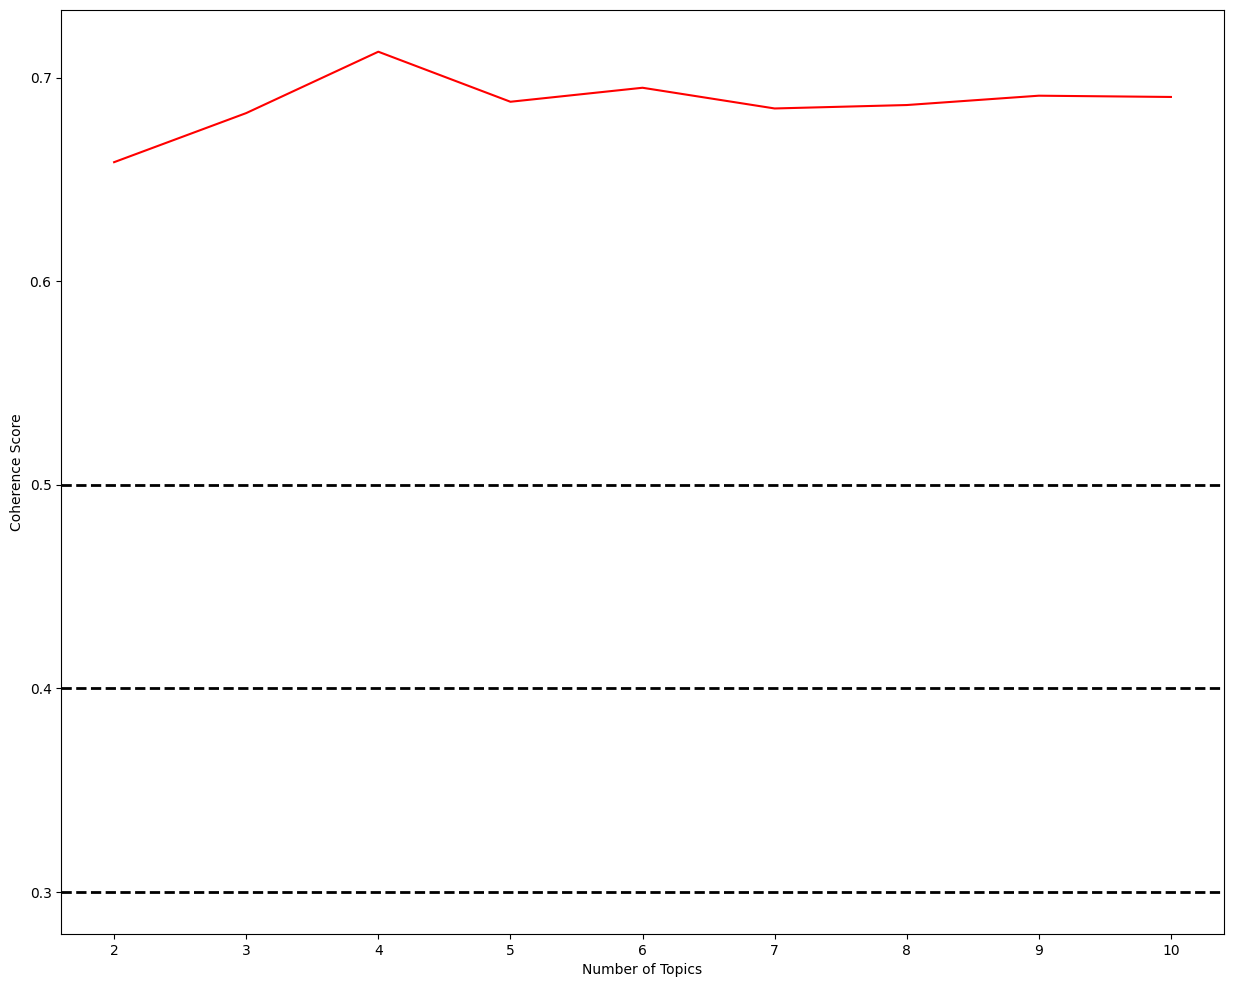

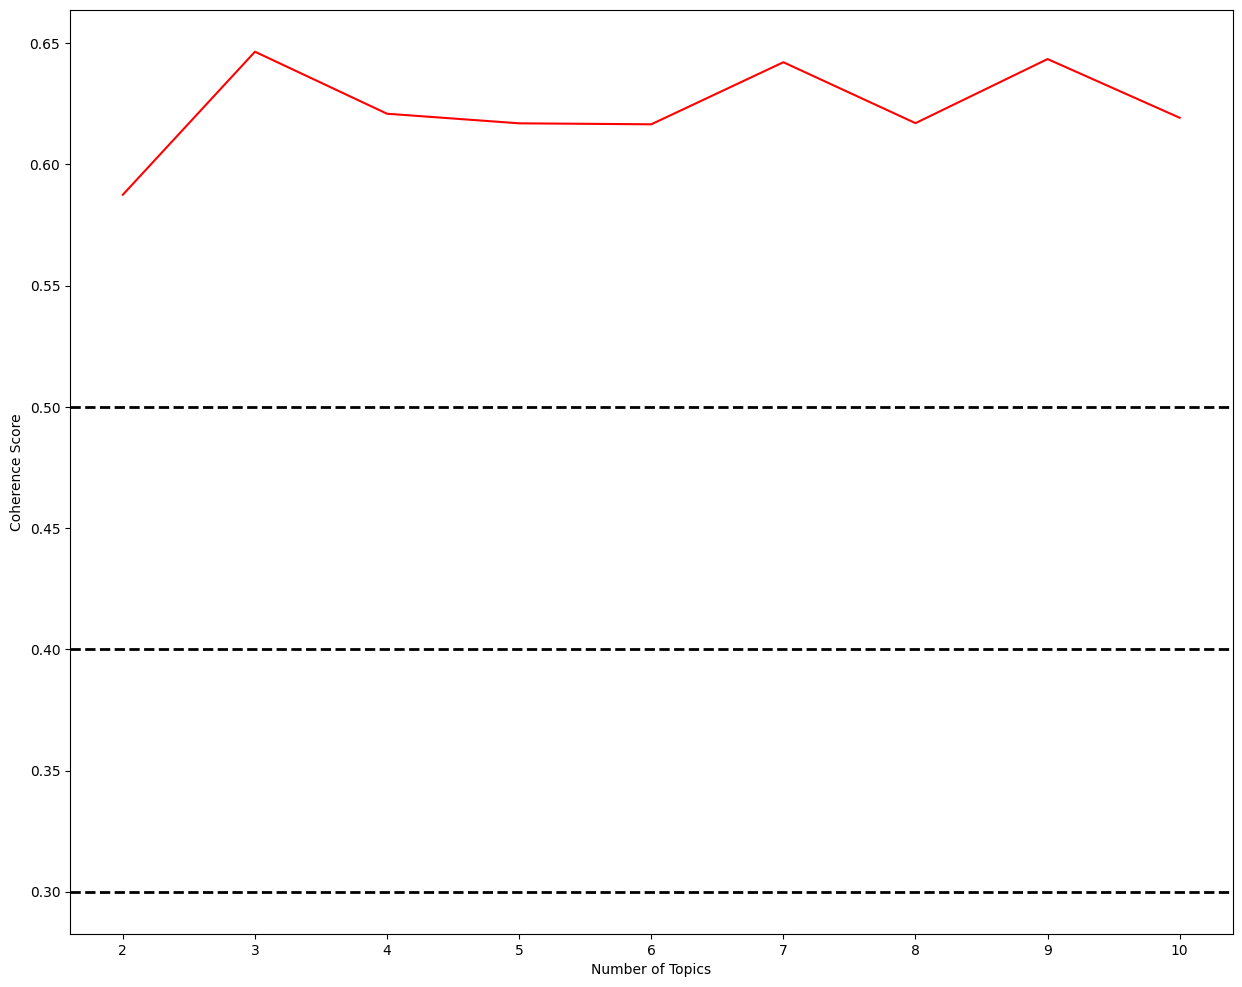


DF NAME: df_neg



  0%|                                                                                            | 0/9 [00:00<?, ?it/s]


MODEL: LSI - NUMBER OF TOPICS: 2


 11%|█████████▏                                                                         | 1/9 [02:13<17:45, 133.14s/it]

Topic #1:
0.344*"staff" + 0.293*"check" + 0.189*"clean" + 0.163*"bed" + 0.155*"good" + 0.152*"book" + 0.146*"even" + 0.145*"ask" + 0.136*"small" + 0.119*"need" + 0.116*"like" + 0.114*"say" + 0.114*"service" + 0.112*"also" + 0.110*"door" + 0.109*"reception" + 0.107*"guest" + 0.105*"pm" + 0.104*"shower" + 0.103*"give"

Topic #2:
0.493*"check" + -0.278*"small" + 0.274*"pm" + -0.242*"bed" + -0.208*"shower" + -0.206*"bathroom" + 0.189*"staff" + 0.161*"wait" + -0.160*"good" + -0.158*"clean" + 0.140*"tell" + -0.137*"toilet" + 0.135*"ask" + -0.126*"smell" + -0.113*"dirty" + 0.112*"call" + 0.110*"say" + -0.097*"water" + -0.095*"floor" + 0.090*"book"

--------------------------------------------------

MODEL: LSI - NUMBER OF TOPICS: 3


 22%|██████████████████▍                                                                | 2/9 [04:29<15:45, 135.03s/it]

Topic #1:
0.344*"staff" + 0.293*"check" + 0.190*"clean" + 0.164*"bed" + 0.155*"good" + 0.152*"book" + 0.146*"even" + 0.145*"ask" + 0.137*"small" + 0.119*"need" + 0.116*"like" + 0.114*"say" + 0.113*"service" + 0.112*"also" + 0.110*"door" + 0.109*"reception" + 0.107*"guest" + 0.105*"shower" + 0.104*"pm" + 0.103*"give"

Topic #2:
0.442*"check" + 0.317*"staff" + -0.305*"bed" + -0.282*"small" + 0.227*"pm" + -0.211*"bathroom" + -0.206*"shower" + -0.158*"clean" + 0.155*"wait" + -0.146*"toilet" + -0.143*"good" + -0.133*"smell" + 0.133*"tell" + -0.116*"dirty" + 0.113*"ask" + 0.103*"say" + -0.101*"floor" + 0.099*"call" + -0.098*"water" + -0.080*"also"

Topic #3:
-0.704*"staff" + 0.361*"check" + 0.269*"bed" + 0.246*"pm" + 0.175*"book" + -0.147*"clean" + -0.134*"good" + -0.102*"friendly" + 0.097*"ask" + 0.091*"door" + 0.083*"wait" + 0.072*"even" + -0.070*"helpful" + 0.069*"next" + -0.066*"breakfast" + -0.066*"nice" + 0.065*"call" + -0.063*"rude" + 0.055*"arrive" + -0.055*"service"

---------------

 33%|███████████████████████████▋                                                       | 3/9 [06:46<13:36, 136.05s/it]

Topic #1:
0.343*"staff" + 0.295*"check" + 0.190*"clean" + 0.165*"bed" + 0.155*"good" + 0.152*"book" + 0.146*"even" + 0.145*"ask" + 0.137*"small" + 0.119*"need" + 0.116*"like" + 0.114*"say" + 0.113*"service" + 0.112*"also" + 0.110*"door" + 0.109*"reception" + 0.107*"guest" + 0.105*"pm" + 0.104*"shower" + 0.103*"give"

Topic #2:
0.445*"check" + 0.305*"staff" + -0.293*"bed" + -0.286*"small" + 0.222*"pm" + -0.212*"bathroom" + -0.209*"shower" + -0.170*"clean" + -0.155*"good" + 0.154*"wait" + -0.148*"toilet" + -0.134*"smell" + 0.132*"tell" + 0.118*"ask" + -0.111*"dirty" + 0.105*"say" + 0.099*"call" + -0.099*"water" + -0.099*"floor" + -0.077*"also"

Topic #3:
-0.693*"staff" + 0.348*"check" + 0.305*"bed" + 0.242*"pm" + 0.183*"book" + -0.150*"clean" + -0.130*"good" + -0.099*"friendly" + -0.094*"breakfast" + 0.091*"door" + 0.091*"ask" + 0.081*"wait" + 0.071*"even" + 0.070*"next" + -0.068*"helpful" + 0.064*"call" + -0.064*"rude" + -0.064*"nice" + -0.059*"food" + -0.055*"service"

Topic #4:
-0.417

 44%|████████████████████████████████████▉                                              | 4/9 [09:05<11:26, 137.25s/it]

Topic #1:
0.343*"staff" + 0.295*"check" + 0.188*"clean" + 0.165*"bed" + 0.156*"good" + 0.153*"book" + 0.147*"even" + 0.145*"ask" + 0.138*"small" + 0.119*"need" + 0.117*"like" + 0.113*"say" + 0.113*"service" + 0.112*"also" + 0.110*"door" + 0.109*"reception" + 0.108*"guest" + 0.105*"pm" + 0.104*"shower" + 0.103*"give"

Topic #2:
0.456*"check" + 0.325*"staff" + -0.277*"bed" + -0.267*"small" + 0.211*"pm" + -0.206*"bathroom" + -0.204*"shower" + -0.189*"clean" + -0.160*"good" + -0.150*"toilet" + 0.149*"wait" + -0.138*"smell" + 0.130*"tell" + -0.114*"dirty" + 0.113*"ask" + -0.100*"floor" + 0.098*"say" + -0.095*"water" + 0.094*"call" + -0.087*"like"

Topic #3:
-0.683*"staff" + 0.349*"check" + 0.320*"bed" + 0.237*"pm" + 0.197*"book" + -0.175*"clean" + -0.118*"good" + -0.098*"friendly" + 0.090*"ask" + -0.088*"breakfast" + 0.086*"door" + 0.076*"wait" + 0.073*"even" + -0.069*"helpful" + 0.065*"next" + -0.063*"nice" + -0.063*"rude" + 0.060*"call" + -0.059*"service" + -0.056*"towel"

Topic #4:
0.506

 56%|██████████████████████████████████████████████                                     | 5/9 [11:26<09:13, 138.42s/it]

Topic #1:
0.344*"staff" + 0.294*"check" + 0.189*"clean" + 0.164*"bed" + 0.155*"good" + 0.153*"book" + 0.147*"even" + 0.145*"ask" + 0.138*"small" + 0.119*"need" + 0.117*"like" + 0.114*"say" + 0.113*"service" + 0.112*"also" + 0.110*"door" + 0.109*"reception" + 0.107*"guest" + 0.105*"pm" + 0.104*"shower" + 0.103*"give"

Topic #2:
0.452*"check" + 0.319*"staff" + -0.283*"bed" + -0.268*"small" + 0.209*"pm" + -0.207*"bathroom" + -0.204*"clean" + -0.201*"shower" + -0.159*"good" + 0.151*"wait" + -0.150*"toilet" + -0.138*"smell" + 0.132*"tell" + -0.116*"dirty" + 0.114*"ask" + 0.101*"say" + -0.099*"floor" + 0.095*"call" + -0.091*"water" + -0.086*"like"

Topic #3:
-0.683*"staff" + 0.353*"check" + 0.332*"bed" + 0.228*"pm" + 0.189*"book" + -0.154*"clean" + -0.129*"good" + -0.097*"friendly" + 0.093*"ask" + -0.091*"breakfast" + 0.091*"door" + 0.074*"wait" + -0.068*"nice" + -0.066*"helpful" + 0.066*"next" + 0.065*"even" + -0.063*"rude" + 0.061*"call" + -0.061*"service" + -0.061*"food"

Topic #4:
0.502*

 67%|███████████████████████████████████████████████████████▎                           | 6/9 [13:48<06:58, 139.55s/it]

Topic #1:
0.344*"staff" + 0.294*"check" + 0.189*"clean" + 0.164*"bed" + 0.156*"good" + 0.153*"book" + 0.147*"even" + 0.145*"ask" + 0.138*"small" + 0.120*"need" + 0.117*"like" + 0.114*"say" + 0.113*"service" + 0.113*"also" + 0.109*"door" + 0.109*"reception" + 0.107*"guest" + 0.105*"pm" + 0.104*"shower" + 0.104*"give"

Topic #2:
0.458*"check" + 0.314*"staff" + -0.289*"bed" + -0.274*"small" + 0.208*"pm" + -0.203*"clean" + -0.201*"bathroom" + -0.198*"shower" + -0.159*"good" + 0.150*"wait" + -0.149*"toilet" + -0.137*"smell" + 0.131*"tell" + -0.116*"dirty" + 0.115*"ask" + 0.100*"say" + -0.097*"floor" + 0.096*"call" + -0.089*"water" + -0.086*"like"

Topic #3:
-0.683*"staff" + 0.355*"check" + 0.319*"bed" + 0.218*"pm" + 0.171*"book" + -0.164*"clean" + -0.142*"good" + -0.111*"breakfast" + -0.100*"friendly" + 0.094*"door" + 0.089*"ask" + 0.071*"wait" + -0.070*"nice" + 0.069*"even" + 0.069*"next" + -0.067*"helpful" + -0.064*"rude" + -0.062*"food" + -0.059*"service" + 0.059*"call"

Topic #4:
0.551*

 78%|████████████████████████████████████████████████████████████████▌                  | 7/9 [16:11<04:41, 140.84s/it]

Topic #1:
0.344*"staff" + 0.294*"check" + 0.189*"clean" + 0.164*"bed" + 0.156*"good" + 0.152*"book" + 0.147*"even" + 0.145*"ask" + 0.138*"small" + 0.120*"need" + 0.117*"like" + 0.113*"say" + 0.113*"service" + 0.113*"also" + 0.110*"door" + 0.109*"reception" + 0.107*"guest" + 0.105*"pm" + 0.104*"shower" + 0.104*"give"

Topic #2:
0.464*"check" + 0.305*"staff" + -0.294*"bed" + -0.274*"small" + -0.206*"clean" + 0.205*"pm" + -0.205*"bathroom" + -0.199*"shower" + -0.160*"good" + 0.149*"wait" + -0.148*"toilet" + -0.138*"smell" + 0.129*"tell" + -0.116*"dirty" + 0.115*"ask" + -0.099*"floor" + 0.097*"call" + 0.095*"say" + -0.086*"water" + -0.085*"like"

Topic #3:
-0.687*"staff" + 0.373*"check" + 0.280*"bed" + 0.215*"pm" + 0.171*"book" + -0.156*"clean" + -0.149*"good" + -0.126*"breakfast" + 0.101*"door" + -0.100*"friendly" + 0.078*"ask" + 0.075*"even" + 0.074*"wait" + -0.068*"nice" + 0.068*"next" + -0.067*"food" + -0.067*"helpful" + -0.062*"rude" + 0.060*"call" + -0.059*"service"

Topic #4:
0.583*

 89%|█████████████████████████████████████████████████████████████████████████▊         | 8/9 [18:36<02:22, 142.22s/it]

Topic #1:
0.343*"staff" + 0.294*"check" + 0.189*"clean" + 0.164*"bed" + 0.156*"good" + 0.152*"book" + 0.147*"even" + 0.145*"ask" + 0.139*"small" + 0.119*"need" + 0.117*"like" + 0.113*"say" + 0.113*"service" + 0.113*"also" + 0.109*"door" + 0.109*"reception" + 0.107*"guest" + 0.105*"pm" + 0.104*"shower" + 0.104*"give"

Topic #2:
0.472*"check" + 0.302*"staff" + -0.291*"bed" + -0.274*"small" + -0.207*"bathroom" + 0.201*"pm" + -0.201*"shower" + -0.189*"clean" + -0.167*"good" + -0.149*"toilet" + 0.143*"wait" + -0.138*"smell" + 0.126*"tell" + -0.116*"dirty" + 0.113*"ask" + -0.100*"floor" + 0.095*"call" + -0.089*"water" + -0.089*"like" + 0.089*"say"

Topic #3:
-0.684*"staff" + 0.378*"check" + 0.297*"bed" + 0.216*"pm" + 0.170*"book" + -0.146*"clean" + -0.142*"good" + -0.131*"breakfast" + 0.099*"door" + -0.098*"friendly" + 0.079*"ask" + 0.078*"even" + 0.072*"wait" + -0.069*"nice" + -0.068*"food" + 0.067*"next" + -0.066*"helpful" + 0.062*"call" + -0.060*"rude" + -0.056*"service"

Topic #4:
0.598*

100%|███████████████████████████████████████████████████████████████████████████████████| 9/9 [21:03<00:00, 140.38s/it]


Topic #1:
0.343*"staff" + 0.294*"check" + 0.189*"clean" + 0.164*"bed" + 0.155*"good" + 0.152*"book" + 0.148*"even" + 0.145*"ask" + 0.139*"small" + 0.119*"need" + 0.117*"like" + 0.113*"say" + 0.113*"service" + 0.113*"also" + 0.110*"door" + 0.109*"reception" + 0.107*"guest" + 0.104*"pm" + 0.104*"shower" + 0.104*"give"

Topic #2:
0.467*"check" + 0.308*"staff" + -0.285*"bed" + -0.282*"small" + -0.207*"bathroom" + -0.207*"shower" + 0.195*"pm" + -0.189*"clean" + -0.168*"good" + -0.157*"toilet" + 0.142*"wait" + -0.133*"smell" + 0.125*"tell" + -0.115*"dirty" + 0.111*"ask" + -0.102*"floor" + -0.097*"water" + 0.095*"call" + 0.088*"say" + -0.087*"like"

Topic #3:
-0.686*"staff" + 0.386*"check" + 0.286*"bed" + 0.220*"pm" + 0.175*"book" + -0.141*"good" + -0.135*"clean" + -0.129*"breakfast" + -0.099*"friendly" + 0.095*"door" + 0.080*"ask" + 0.072*"even" + 0.071*"wait" + -0.069*"nice" + 0.067*"next" + -0.066*"helpful" + -0.066*"food" + 0.062*"call" + -0.060*"rude" + -0.056*"well"

Topic #4:
0.629*"cl

  0%|                                                                                            | 0/9 [00:00<?, ?it/s]


MODEL: LDA - NUMBER OF TOPICS: 2


 11%|█████████▎                                                                          | 1/9 [00:07<00:59,  7.45s/it]

Topic #1:
0.019*"small" + 0.015*"bed" + 0.014*"bathroom" + 0.013*"shower" + 0.013*"toilet" + 0.012*"clean" + 0.012*"smell" + 0.010*"also" + 0.010*"floor" + 0.009*"dirty" + 0.009*"good" + 0.009*"like" + 0.009*"water" + 0.008*"door" + 0.008*"bit" + 0.007*"work" + 0.007*"bad" + 0.007*"old" + 0.006*"area" + 0.006*"window"

Topic #2:
0.020*"staff" + 0.016*"check" + 0.013*"nothing" + 0.012*"breakfast" + 0.012*"small" + 0.010*"clean" + 0.010*"could" + 0.009*"good" + 0.009*"book" + 0.008*"need" + 0.008*"price" + 0.008*"bit" + 0.007*"service" + 0.007*"well" + 0.007*"reception" + 0.007*"bed" + 0.006*"like" + 0.006*"ask" + 0.006*"pay" + 0.006*"even"

--------------------------------------------------

MODEL: LDA - NUMBER OF TOPICS: 3


 22%|██████████████████▋                                                                 | 2/9 [00:14<00:50,  7.18s/it]

Topic #1:
0.045*"nothing" + 0.018*"price" + 0.015*"bit" + 0.015*"staff" + 0.014*"small" + 0.014*"like" + 0.012*"good" + 0.011*"book" + 0.010*"well" + 0.009*"bed" + 0.008*"could" + 0.008*"facility" + 0.007*"much" + 0.007*"cleanliness" + 0.007*"view" + 0.007*"size" + 0.007*"clean" + 0.007*"breakfast" + 0.006*"area" + 0.006*"look"

Topic #2:
0.025*"small" + 0.021*"clean" + 0.020*"bathroom" + 0.016*"bed" + 0.016*"smell" + 0.014*"good" + 0.012*"shower" + 0.010*"need" + 0.009*"toilet" + 0.009*"dirty" + 0.009*"bit" + 0.009*"breakfast" + 0.008*"little" + 0.008*"could" + 0.008*"floor" + 0.008*"staff" + 0.007*"service" + 0.007*"space" + 0.007*"bad" + 0.006*"old"

Topic #3:
0.018*"check" + 0.017*"staff" + 0.008*"reception" + 0.008*"could" + 0.008*"also" + 0.008*"water" + 0.008*"use" + 0.008*"even" + 0.008*"door" + 0.008*"breakfast" + 0.007*"like" + 0.007*"small" + 0.006*"guest" + 0.006*"work" + 0.006*"need" + 0.006*"bed" + 0.006*"ask" + 0.006*"toilet" + 0.006*"shower" + 0.006*"book"

------------

 33%|████████████████████████████                                                        | 3/9 [00:21<00:41,  7.00s/it]

Topic #1:
0.027*"bathroom" + 0.023*"small" + 0.021*"bed" + 0.021*"smell" + 0.016*"clean" + 0.016*"shower" + 0.015*"toilet" + 0.013*"dirty" + 0.013*"like" + 0.011*"window" + 0.010*"old" + 0.009*"bit" + 0.008*"work" + 0.007*"floor" + 0.007*"book" + 0.007*"people" + 0.007*"hostel" + 0.007*"water" + 0.006*"bad" + 0.006*"use"

Topic #2:
0.017*"small" + 0.013*"clean" + 0.011*"staff" + 0.011*"could" + 0.010*"bit" + 0.009*"bed" + 0.009*"breakfast" + 0.008*"shower" + 0.008*"also" + 0.008*"well" + 0.007*"floor" + 0.007*"need" + 0.007*"good" + 0.007*"door" + 0.007*"check" + 0.006*"toilet" + 0.006*"area" + 0.006*"water" + 0.006*"service" + 0.006*"use"

Topic #3:
0.046*"nothing" + 0.021*"check" + 0.020*"good" + 0.017*"staff" + 0.014*"breakfast" + 0.011*"service" + 0.011*"need" + 0.008*"pm" + 0.008*"could" + 0.007*"everything" + 0.007*"food" + 0.007*"pay" + 0.007*"wait" + 0.006*"hour" + 0.006*"book" + 0.006*"bed" + 0.006*"say" + 0.006*"bit" + 0.006*"clean" + 0.006*"around"

Topic #4:
0.029*"staff" +

 44%|█████████████████████████████████████▎                                              | 4/9 [00:27<00:33,  6.78s/it]

Topic #1:
0.022*"staff" + 0.020*"check" + 0.017*"breakfast" + 0.014*"service" + 0.013*"book" + 0.013*"need" + 0.012*"pay" + 0.009*"give" + 0.008*"charge" + 0.008*"clean" + 0.008*"ask" + 0.008*"even" + 0.007*"could" + 0.007*"reception" + 0.006*"pm" + 0.006*"tell" + 0.006*"food" + 0.006*"extra" + 0.006*"restaurant" + 0.006*"pool"

Topic #2:
0.022*"check" + 0.021*"staff" + 0.013*"door" + 0.011*"reception" + 0.010*"guest" + 0.010*"could" + 0.010*"even" + 0.009*"noise" + 0.009*"smell" + 0.008*"hear" + 0.008*"make" + 0.008*"use" + 0.007*"come" + 0.007*"people" + 0.007*"open" + 0.007*"also" + 0.007*"long" + 0.007*"next" + 0.007*"book" + 0.006*"clean"

Topic #3:
0.066*"nothing" + 0.016*"like" + 0.012*"clean" + 0.011*"small" + 0.010*"water" + 0.009*"could" + 0.009*"door" + 0.009*"little" + 0.009*"also" + 0.008*"bit" + 0.008*"coffee" + 0.008*"bathroom" + 0.008*"say" + 0.007*"ask" + 0.007*"make" + 0.007*"bed" + 0.006*"service" + 0.006*"really" + 0.006*"wash" + 0.006*"two"

Topic #4:
0.045*"small"

 56%|██████████████████████████████████████████████▋                                     | 5/9 [00:33<00:26,  6.59s/it]

Topic #1:
0.019*"bed" + 0.019*"staff" + 0.014*"check" + 0.014*"change" + 0.011*"even" + 0.009*"use" + 0.009*"book" + 0.008*"request" + 0.008*"reception" + 0.007*"bathroom" + 0.007*"could" + 0.007*"make" + 0.007*"leave" + 0.007*"dirty" + 0.007*"know" + 0.007*"person" + 0.006*"say" + 0.006*"light" + 0.006*"break" + 0.006*"small"

Topic #2:
0.028*"small" + 0.022*"bit" + 0.019*"bathroom" + 0.017*"shower" + 0.016*"dirty" + 0.016*"cold" + 0.015*"price" + 0.014*"toilet" + 0.012*"noisy" + 0.011*"space" + 0.010*"work" + 0.010*"everything" + 0.009*"people" + 0.009*"area" + 0.009*"little" + 0.009*"water" + 0.008*"old" + 0.008*"pool" + 0.008*"wall" + 0.008*"also"

Topic #3:
0.061*"nothing" + 0.040*"small" + 0.020*"like" + 0.014*"bathroom" + 0.012*"really" + 0.009*"could" + 0.009*"window" + 0.008*"check" + 0.008*"size" + 0.008*"good" + 0.007*"bed" + 0.007*"feel" + 0.007*"book" + 0.006*"bit" + 0.006*"price" + 0.006*"singapore" + 0.006*"clean" + 0.006*"space" + 0.006*"look" + 0.006*"old"

Topic #4:
0

 67%|████████████████████████████████████████████████████████                            | 6/9 [00:40<00:19,  6.51s/it]

Topic #1:
0.029*"shower" + 0.025*"clean" + 0.022*"bed" + 0.019*"bathroom" + 0.019*"toilet" + 0.019*"check" + 0.013*"small" + 0.012*"coffee" + 0.012*"bit" + 0.010*"work" + 0.010*"bad" + 0.009*"water" + 0.009*"common" + 0.008*"need" + 0.008*"also" + 0.008*"could" + 0.008*"long" + 0.008*"smell" + 0.008*"book" + 0.008*"cleanliness"

Topic #2:
0.046*"small" + 0.027*"bit" + 0.025*"good" + 0.019*"smell" + 0.017*"breakfast" + 0.014*"little" + 0.013*"bathroom" + 0.012*"staff" + 0.012*"food" + 0.011*"area" + 0.009*"need" + 0.009*"space" + 0.009*"clean" + 0.009*"bad" + 0.008*"well" + 0.008*"price" + 0.007*"far" + 0.007*"really" + 0.007*"size" + 0.007*"could"

Topic #3:
0.033*"nothing" + 0.015*"staff" + 0.012*"could" + 0.012*"clean" + 0.011*"bed" + 0.011*"good" + 0.009*"bathroom" + 0.008*"also" + 0.008*"floor" + 0.008*"like" + 0.007*"even" + 0.007*"toilet" + 0.007*"make" + 0.007*"sleep" + 0.007*"well" + 0.007*"small" + 0.007*"check" + 0.006*"use" + 0.006*"see" + 0.006*"shower"

Topic #4:
0.017*"li

 78%|█████████████████████████████████████████████████████████████████▎                  | 7/9 [00:46<00:12,  6.41s/it]

Topic #1:
0.035*"good" + 0.028*"bit" + 0.016*"need" + 0.015*"little" + 0.014*"small" + 0.014*"price" + 0.014*"clean" + 0.012*"bathroom" + 0.012*"breakfast" + 0.011*"everything" + 0.010*"noise" + 0.010*"quite" + 0.010*"could" + 0.009*"well" + 0.009*"area" + 0.009*"window" + 0.009*"food" + 0.008*"really" + 0.008*"far" + 0.008*"cleanliness"

Topic #2:
0.021*"clean" + 0.019*"smell" + 0.017*"shower" + 0.016*"toilet" + 0.014*"bathroom" + 0.014*"floor" + 0.013*"bed" + 0.012*"could" + 0.010*"like" + 0.009*"cold" + 0.009*"water" + 0.009*"noisy" + 0.008*"work" + 0.008*"door" + 0.007*"well" + 0.007*"also" + 0.007*"small" + 0.007*"light" + 0.007*"make" + 0.006*"sleep"

Topic #3:
0.045*"small" + 0.022*"bed" + 0.015*"shower" + 0.014*"bathroom" + 0.013*"really" + 0.012*"wash" + 0.011*"need" + 0.011*"people" + 0.011*"take" + 0.010*"staff" + 0.010*"like" + 0.009*"table" + 0.008*"door" + 0.008*"sleep" + 0.008*"area" + 0.007*"check" + 0.007*"even" + 0.007*"toilet" + 0.007*"also" + 0.007*"use"

Topic #4:


 89%|██████████████████████████████████████████████████████████████████████████▋         | 8/9 [00:52<00:06,  6.33s/it]

Topic #1:
0.048*"check" + 0.020*"smell" + 0.018*"staff" + 0.016*"pm" + 0.016*"wait" + 0.014*"even" + 0.013*"cold" + 0.010*"could" + 0.009*"like" + 0.009*"long" + 0.009*"good" + 0.009*"ask" + 0.009*"bad" + 0.008*"reception" + 0.008*"nail" + 0.007*"hour" + 0.007*"need" + 0.007*"late" + 0.007*"around" + 0.006*"even_though"

Topic #2:
0.042*"pool" + 0.033*"staff" + 0.024*"quite" + 0.023*"bit" + 0.022*"clean" + 0.019*"area" + 0.016*"small" + 0.015*"common" + 0.012*"ok" + 0.010*"dirty" + 0.010*"friendly" + 0.010*"crowd" + 0.010*"much" + 0.010*"smell" + 0.010*"could" + 0.010*"helpful" + 0.009*"need" + 0.009*"date" + 0.009*"also" + 0.009*"build"

Topic #3:
0.047*"small" + 0.028*"shower" + 0.024*"bathroom" + 0.022*"bit" + 0.022*"clean" + 0.016*"water" + 0.016*"toilet" + 0.011*"also" + 0.011*"wash" + 0.010*"size" + 0.009*"space" + 0.009*"bed" + 0.009*"like" + 0.009*"cleanliness" + 0.009*"floor" + 0.009*"good" + 0.008*"noise" + 0.007*"smell" + 0.007*"need" + 0.007*"could"

Topic #4:
0.069*"breakf

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:58<00:00,  6.54s/it]

Topic #1:
0.037*"service" + 0.028*"staff" + 0.020*"clean" + 0.016*"none" + 0.012*"call" + 0.011*"guest" + 0.010*"reception" + 0.010*"anything" + 0.010*"make" + 0.009*"book" + 0.008*"around" + 0.008*"area" + 0.008*"change" + 0.007*"take" + 0.007*"leave" + 0.007*"breakfast" + 0.007*"quickly" + 0.007*"even" + 0.007*"well" + 0.007*"want"

Topic #2:
0.021*"staff" + 0.013*"check" + 0.013*"reception" + 0.012*"give" + 0.011*"like" + 0.010*"door" + 0.009*"use" + 0.009*"leave" + 0.009*"ask" + 0.008*"breakfast" + 0.008*"take" + 0.008*"clean" + 0.007*"thing" + 0.007*"could" + 0.006*"even" + 0.006*"say" + 0.006*"come" + 0.006*"guest" + 0.006*"make" + 0.006*"week"

Topic #3:
0.030*"staff" + 0.023*"toilet" + 0.015*"shower" + 0.015*"clean" + 0.013*"water" + 0.013*"work" + 0.012*"floor" + 0.012*"bathroom" + 0.011*"need" + 0.010*"check" + 0.010*"towel" + 0.009*"pool" + 0.009*"service" + 0.008*"friendly" + 0.008*"hot" + 0.007*"rude" + 0.007*"issue" + 0.007*"break" + 0.007*"guest" + 0.006*"reception"

Top

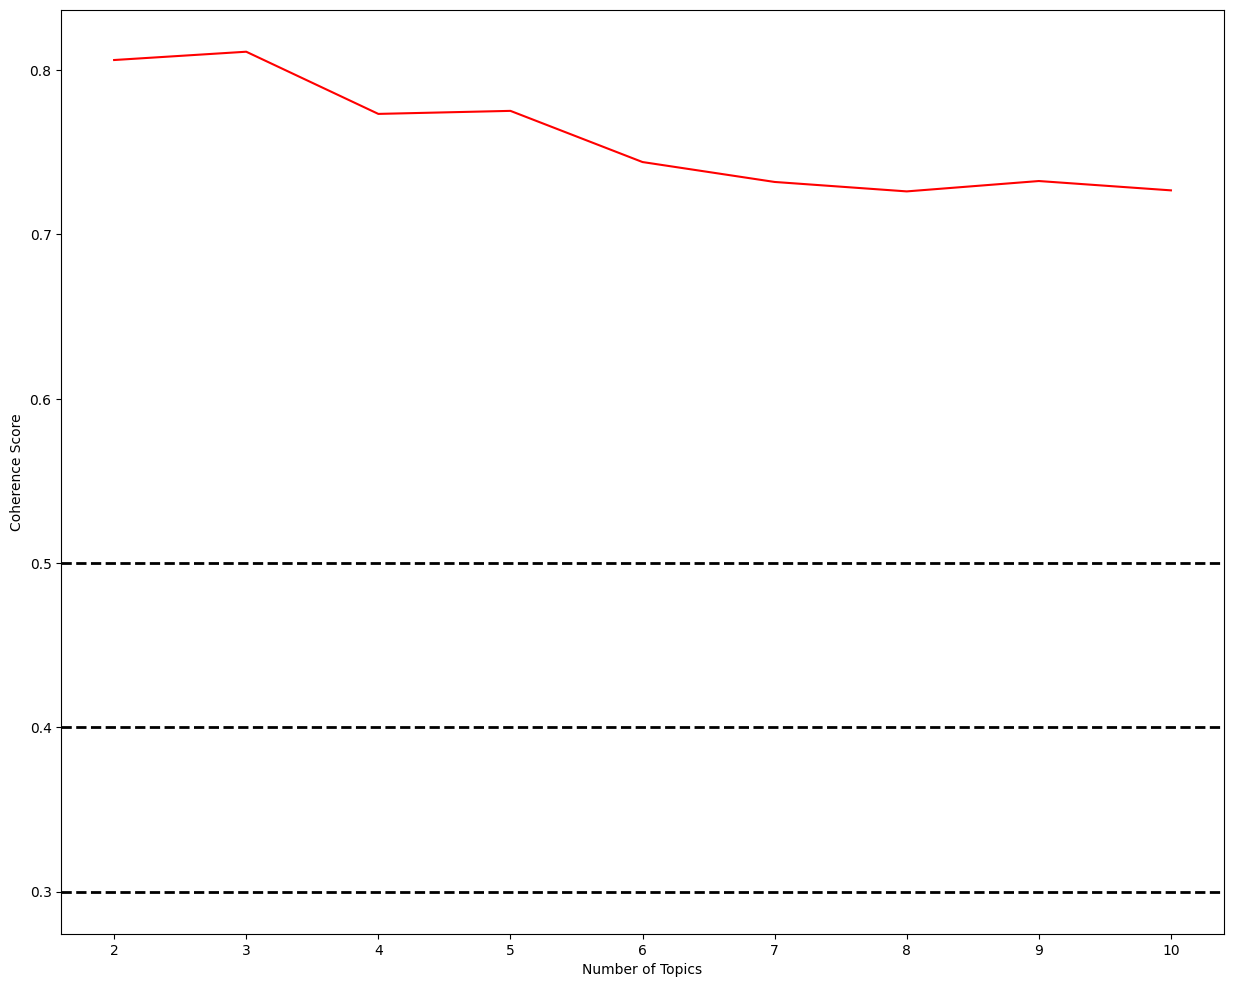

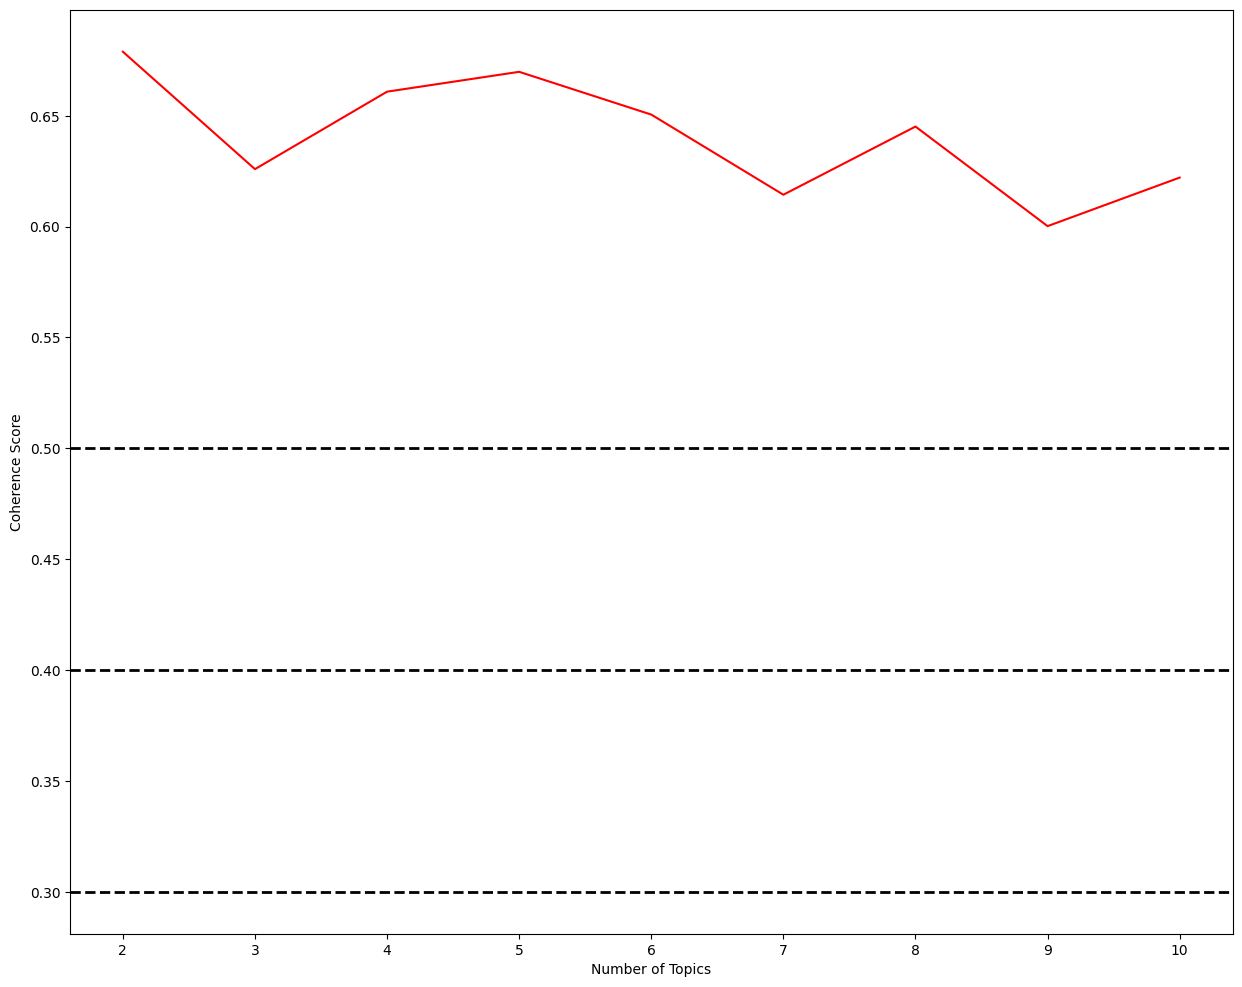

In [9]:
# Calculate coherence scores for each model
target_text = "review_cleaned_v2"

overall_coherence_df = pd.DataFrame() # df to store coherence_df
model_topic_info_list = []  # List to store model_topic_info

for i, df_set in enumerate(df_sets):
    
    print("\nDF NAME: {}\n".format(df_names[i]))

    coherence_df, model_topic_info = topic_model_coherence_plot(df_set, df_names[i], target_text, MODEL_NAMES, START_TOPIC_COUNT, END_TOPIC_COUNT)
    overall_coherence_df = pd.concat([overall_coherence_df, coherence_df], axis=0) # Concatenate to overall_coherence_df
    model_topic_info_list.append(model_topic_info) # Store model_topic_info in a list

In [10]:
# Print all models' coherence scores
overall_coherence_df

,Model Name,Number of Topics,Coherence Score,df_name
0,LSI,2,0.658499,df_pos
1,LSI,3,0.682622,df_pos
2,LSI,4,0.712774,df_pos
3,LSI,5,0.688188,df_pos
4,LSI,6,0.695065,df_pos
5,LSI,7,0.684891,df_pos
6,LSI,8,0.686576,df_pos
7,LSI,9,0.691165,df_pos
8,LSI,10,0.690544,df_pos
0,LDA,2,0.587528,df_pos


In [11]:
# Store coherence scores of all models into "overall_coherence_df", sort by "df_name" and "Coherence Score"
overall_coherence_df = overall_coherence_df.sort_values(["df_name", "Coherence Score"], ascending=False).reset_index(drop=True)
#overall_coherence_df

# Find best model for each df
overall_coherence_best_df = overall_coherence_df.loc[overall_coherence_df.groupby("df_name")["Coherence Score"].idxmax()].reset_index(drop=True)
overall_coherence_best_df

,Model Name,Number of Topics,Coherence Score,df_name
0,LSI,3,0.811182,df_neg
1,LSI,4,0.712774,df_pos


In [12]:
# Print topics of best model
print_best_model_topics(overall_coherence_best_df, model_topic_info_list)


DF NAME: df_neg
MODEL: LSI - NUMBER OF TOPICS: 3

Topic 1: staff, check, clean, bed, good, book, even, ask, small, need

Topic 2: check, staff, bed, small, pm, bathroom, shower, clean, wait, toilet

Topic 3: staff, check, bed, pm, book, clean, good, friendly, ask, door

----------


DF NAME: df_pos
MODEL: LSI - NUMBER OF TOPICS: 4

Topic 1: good, staff, clean, great, nice, friendly, also, check, small, bed

Topic 2: good, staff, great, check, friendly, clean, helpful, nice, book, also

Topic 3: staff, friendly, good, small, bed, helpful, also, shower, bathroom, book

Topic 4: clean, check, book, great, near, pm, nice, meet, ask, tell

----------



In [13]:
end_time = datetime.now()
print("Text processing ended at {}".format(end_time))
print("Text processing spent {}".format(end_time - start_time))

Text processing ended at 2024-06-27 04:08:19.888486
Text processing spent 2:00:54.936954
